In [38]:
import pickle
import pandas as pd

In [33]:
df_path = 'output/TUS_source_all_target_all/seed1/graph_stats_with_groundtruth_df.pickle'
df = pickle.load(open(df_path, 'rb'))
df = df[df['node_type'] == 'cell']
df = df.sort_values(by=['approximate_betweenness_centrality'], ascending=False)
df.loc[:,'rank'] = list(range(1, df.shape[0] + 1))
df['average_rank'] = df['approximate_betweenness_centrality'].rank(method='average', ascending=False)
df['dense_rank'] = df['approximate_betweenness_centrality'].rank(method='dense', ascending=False)
df

,node,node_type,approximate_betweenness_centrality,is_homograph,has_missing_key,rank,average_rank,dense_rank
65462,Music Faculty,cell,0.000639,True,False,1,1.0,1.0
28669,Manitoba Hydro,cell,0.000448,True,False,2,2.0,2.0
10223,50,cell,0.000293,True,False,3,3.0,3.0
47053,1800ZZMALDY2,cell,0.000281,True,False,4,4.0,4.0
70313,.,cell,0.000278,True,False,5,5.0,5.0
...,...,...,...,...,...,...,...,...
126117,Route revised \n\n,cell,0.000000,False,False,190395,139574.0,2796.0
126116,Route and Timetable revised as per schedules l...,cell,0.000000,False,False,190396,139574.0,2796.0
126115,Route and Timetable revised as per schedules l...,cell,0.000000,False,False,190397,139574.0,2796.0
126114,MON - FRI [EXCEPT PUBLIC HOLIDAYS] ONE JOURNEY...,cell,0.000000,False,False,190398,139574.0,2796.0


In [53]:
cur_dense_rank = -1
tie_group_rank_to_node_id_dict = {}
tie_group = []

# Identify the nodes/indices for each tie group
for index, row in df.iterrows():
    if row['dense_rank'] != cur_dense_rank:
        if len(tie_group) > 1:
            tie_group_rank_to_node_id_dict[cur_dense_rank] = tie_group
            tie_group = []
        # Update the current dense rank
        cur_dense_rank = row['dense_rank']
    else:
        tie_group.append(index)

print('There are a total of', len(tie_group_rank_to_node_id_dict), 'tie groups.')

There are a total of 1043 tie groups.


In [59]:
tie_group_stats_dict = {'rank': [], 'size': [], 'num_homographs': [], 'num_unambiguous_values': [], 'is_influential': [], 'score': []}

# Populate the tie group stats dictionary
for tie_group_rank in tie_group_rank_to_nodes_dict:
    tie_group_stats_dict['rank'].append(tie_group_rank)
    tie_group_stats_dict['size'].append(len(tie_group_rank_to_nodes_dict[tie_group_rank]))

    score = df.loc[df['dense_rank'] == tie_group_rank]['approximate_betweenness_centrality'].values[0]
    tie_group_stats_dict['score'].append(score)

    num_homographs = 0
    num_unambiguous_values = 0
    for node_id in tie_group_rank_to_nodes_dict[tie_group_rank]:
        if df.loc[node_id]['is_homograph']:
            num_homographs += 1
        else:
            num_unambiguous_values += 1

    tie_group_stats_dict['num_homographs'].append(num_homographs)
    tie_group_stats_dict['num_unambiguous_values'].append(num_unambiguous_values)

    if num_homographs > 0 and num_unambiguous_values > 0:
        tie_group_stats_dict['is_influential'].append(True)
    else:
        tie_group_stats_dict['is_influential'].append(False)

df_tie_groups = pd.DataFrame(tie_group_stats_dict)
df_tie_groups = df_tie_groups.sort_values(by=['rank'])
print('There are', df_tie_groups['size'].sum(), 'nodes that are in a tie group')
df_tie_groups

There are 85953 nodes that are in a tie group


,rank,size,num_homographs,num_unambiguous_values,is_influential,score
0,18.0,2,2,0,False,8.515593e-05
1,55.0,2,2,0,False,1.874748e-05
2,80.0,2,2,0,False,1.291445e-05
3,83.0,5,0,5,False,1.234669e-05
4,93.0,3,3,0,False,1.024500e-05
...,...,...,...,...,...,...
1038,2791.0,295,0,295,False,6.493750e-14
1039,2792.0,3273,0,3273,False,6.096821e-14
1040,2793.0,4726,0,4726,False,4.922942e-14
1041,2794.0,4192,0,4192,False,4.756509e-14


In [76]:
df_influential_tie_groups = df_tie_groups[df_tie_groups['is_influential'] == True]
df_non_influential_tie_groups = df_tie_groups[df_tie_groups['is_influential'] == False]
print('There are', df_influential_tie_groups['size'].sum(), 'nodes that are in an influential tie group, out of which', df_influential_tie_groups['num_homographs'].sum(), 'are homographs.')
print('There are', df_non_influential_tie_groups['size'].sum(), 'nodes that are in a non-influential tie group', df_non_influential_tie_groups['num_homographs'].sum(), 'are homographs.')

There are 2259 nodes that are in an influential tie group, out of which 541 are homographs.
There are 83694 nodes that are in a non-influential tie group 16628 are homographs.


In [86]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (19,12)

font = {'size'   : 22}
matplotlib.rc('font', **font)

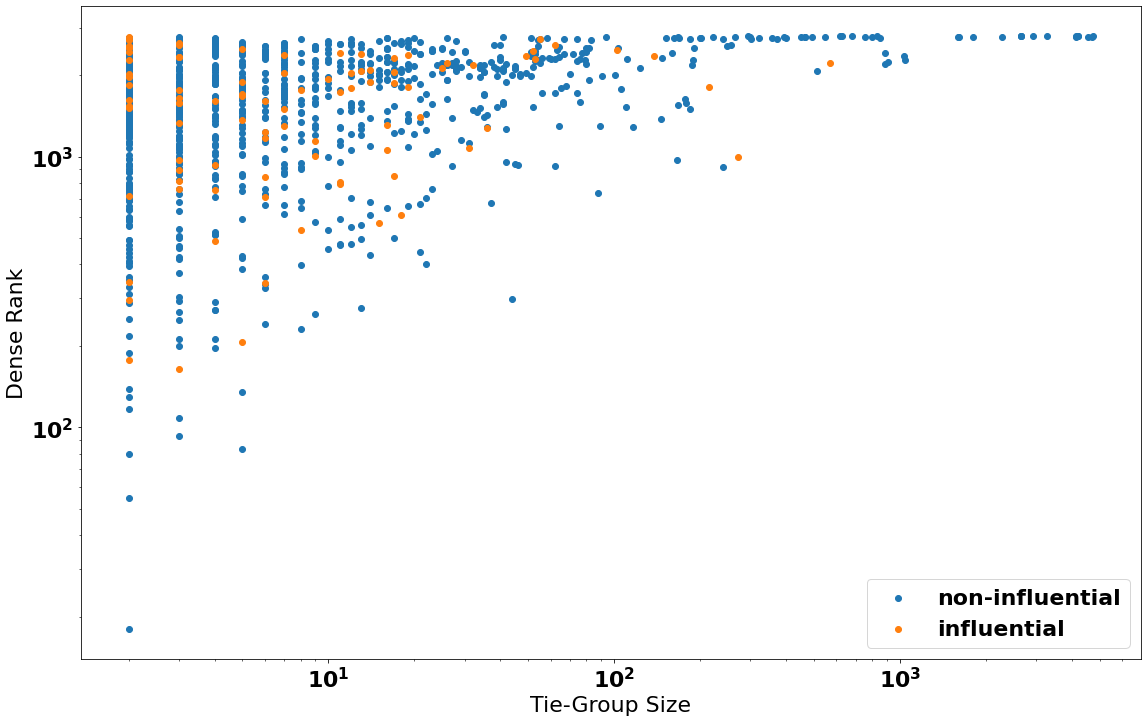

In [98]:
plt.scatter(df_non_influential_tie_groups['size'].values, df_non_influential_tie_groups['rank'].values, label='non-influential')
plt.scatter(df_influential_tie_groups['size'].values, df_influential_tie_groups['rank'].values, label='influential')
plt.xlabel('Tie-Group Size')
plt.ylabel('Dense Rank')
plt.yscale('log')
plt.xscale('log')
plt.legend()

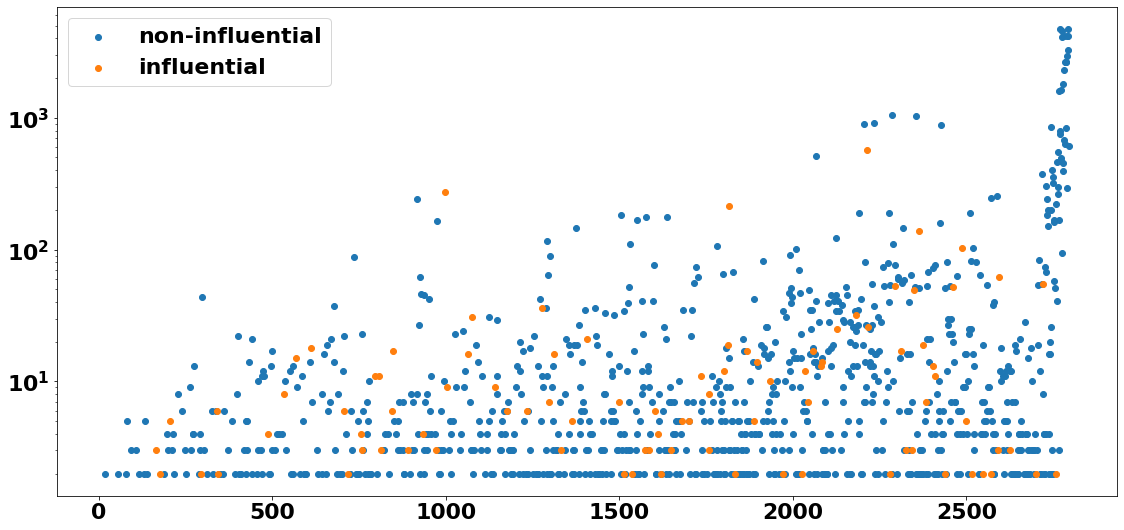

In [73]:
plt.scatter(df_non_influential_tie_groups['rank'].values, df_non_influential_tie_groups['size'].values, label='non-influential')
plt.scatter(df_influential_tie_groups['rank'].values, df_influential_tie_groups['size'].values, label='influential')
plt.yscale('log')
# plt.xscale('log')
plt.legend()